In [12]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
from functools import partial
import makassar_ml as ml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import seaborn as sns
from sklearn.model_selection import ParameterGrid
sns.set() # Use seaborn themes.

# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [13]:
keras.backend.clear_session()

In [14]:
# Configure root paths.
config_roots = dict(
    hp_tuning_root=Path('~/research/makassar/hp_tuning').expanduser(),
)

In [15]:
epochs = 30
batch_size = 256

In [16]:
# Load the dataset.
dataset_kwargs = dict(
    timeseries_path=str(Path('~/research/makassar/datasets/beijing_pm25').expanduser()),
    timeseries_datetime_column='datetime',
    timeseries_features_in=['TEMP','DEWP','PRES','Iws'],
    timeseries_timedelta_dict_in=dict(hours=24),
    timeseries_features_out=['pm2.5','Ir'],
    timeseries_timedelta_dict_out=dict(hours=1),
    timeseries_reserve_offset_index_in=24,
    timeseries_reserve_offset_index_out=1,
    image_shape=[72,72,3],
    split=['train[0%:70%]', 'train[70%:90%]', 'train[90%:]'],
    shuffle_files=False,
)
dataset_train, dataset_val, dataset_test = ml.datasets.fused_plant_village_beijingpm25_regression.load_data(
    **dataset_kwargs,
    batch_size=batch_size,
)
n_batches = tf.data.experimental.cardinality(dataset_train)
n_steps = n_batches*epochs

In [17]:
for i,((b_image, b_ts_in), b_ts_out) in enumerate(dataset_train):
    print(f"{b_image.shape=}")
    print(f"{b_ts_in.shape=}")
    print(f"{b_ts_out.shape=}")
    break

for i,((b_image, b_ts_in), b_ts_out) in enumerate(dataset_val):
    print(f"{b_image.shape=}")
    print(f"{b_ts_in.shape=}")
    print(f"{b_ts_out.shape=}")
    break

for i,((b_image, b_ts_in), b_ts_out) in enumerate(dataset_test):
    print(f"{b_image.shape=}")
    print(f"{b_ts_in.shape=}")
    print(f"{b_ts_out.shape=}")
    break

b_image.shape=TensorShape([256, 72, 72, 3])
b_ts_in.shape=TensorShape([256, 24, 4])
b_ts_out.shape=TensorShape([256, 1, 2])
b_image.shape=TensorShape([256, 72, 72, 3])
b_ts_in.shape=TensorShape([256, 24, 4])
b_ts_out.shape=TensorShape([256, 1, 2])
b_image.shape=TensorShape([256, 72, 72, 3])
b_ts_in.shape=TensorShape([256, 24, 4])
b_ts_out.shape=TensorShape([256, 1, 2])


In [18]:
print(f"{epochs=}")
print(f"{n_batches=}")
print(f"{n_steps=}")

epochs=30
n_batches=<tf.Tensor: shape=(), dtype=int64, numpy=149>
n_steps=<tf.Tensor: shape=(), dtype=int64, numpy=4470>


In [9]:
# Build and compile the model.
model = ml.models.FuT_image_timeseries_regression(
    image_shape=dataset_kwargs['image_shape'],
    in_seq_shape=(dataset_kwargs['timeseries_reserve_offset_index_in'],len(dataset_kwargs['timeseries_features_in'])),
    out_seq_shape=(dataset_kwargs['timeseries_reserve_offset_index_out'],len(dataset_kwargs['timeseries_features_out'])),
    patch_size=6,
    image_embed_dim=16,
    seq_embed_dim=5,
    fusion_embed_dim=10,
    n_heads=8,
    ff_dim=256,
    dropout=0.1,
    n_encoders=3,
)
# optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# optimizer = keras.optimizers.Adam(
#     keras.experimental.CosineDecayRestarts(
#         initial_learning_rate=1e-3,
#         first_decay_steps=1000,
#         )
# )
learning_rate = keras.experimental.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=n_steps,
    alpha=0.1,
)
# learning_rate = keras.experimental.CosineDecayRestarts(
#     initial_learning_rate=1e-3,
#     first_decay_steps=n_steps//3,
#     m_mul=0.8,
# )
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
metrics = ['mae','mape']
model.compile(
    optimizer=optimizer,
    # loss='mse',
    loss=keras.losses.MeanSquaredError(),
    metrics=metrics,
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 24, 4)]      0                                            
__________________________________________________________________________________________________
patches (Patches)               (None, 144, 108)     0           input_1[0][0]                    
__________________________________________________________________________________________________
time2_vec (Time2Vec)            (None, 24, 20)       528         input_2[0][0]                    
____________________________________________________________________________________________

(<tf.Tensor: shape=(), dtype=float32, numpy=0.001>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00010010002>)

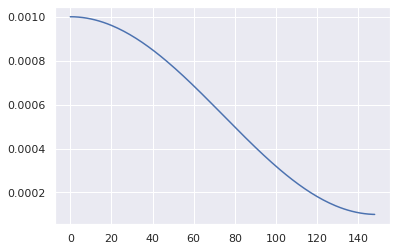

In [10]:
steps = np.arange(n_steps)
lrs = learning_rate(steps)
plt.plot(steps, lrs)
lrs[0],lrs[-1]

In [11]:
# Train.
# strategy = tf.distribute.get_strategy()
history = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=epochs,
    verbose=1,
)

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Can not squeeze dim[2], expected a dimension of 1, got 2
	 [[node mean_squared_error/remove_squeezable_dimensions/Squeeze (defined at tmp/ipykernel_8054/438478851.py:3) ]]
	 [[gradient_tape/model_2/patch_encoder/embedding/embedding_lookup/Reshape/_214]]
  (1) Invalid argument:  Can not squeeze dim[2], expected a dimension of 1, got 2
	 [[node mean_squared_error/remove_squeezable_dimensions/Squeeze (defined at tmp/ipykernel_8054/438478851.py:3) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_15687]

Function call stack:
train_function -> train_function


/tmp/ipykernel_4085/2114538881.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


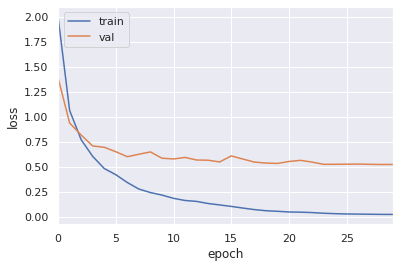

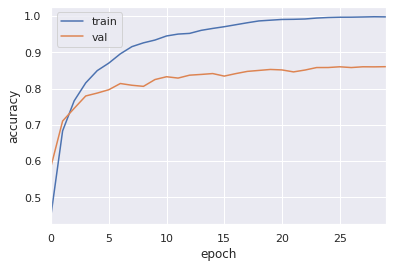

In [ ]:
for key in ['loss']+metrics:
    fig = ml.visualization.plot_metric(history.history, key)
    fig.show()